In [ ]:
!pip install emoji

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import re
import codecs
import emoji
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import feature_extraction, pipeline, metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import random


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install gensim

In [ ]:
data_file = '/content/all_annotated.tsv'
data = pd.read_csv(data_file,sep='\t')

In [ ]:

data

,Tweet ID,Country,Date,Tweet,Definitely English,Ambiguous,Definitely Not English,Code-Switched,Ambiguous due to Named Entities,Automatically Generated Tweets
0,434215992731136000,TR,2014-02-14,Bugün bulusmami lazimdiii,0,0,1,0,0,0
1,285903159434563584,TR,2013-01-01,Volkan konak adami tribe sokar yemin ederim :D,0,0,1,0,0,0
2,285948076496142336,NL,2013-01-01,Bed,1,0,0,0,0,0
3,285965965118824448,US,2013-01-01,I felt my first flash of violence at some fool...,1,0,0,0,0,0
4,286057979831275520,US,2013-01-01,Ladies drink and get in free till 10:30,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
10497,774941788247298050,TR,2016-09-11,"I'm at @PiazzaAvym in Canik, Samsun w/ @mertar...",1,0,0,0,0,1
10498,774951242422480897,PH,2016-09-11,"El Nido, fica ao norte de Palawan, uma das ilh...",0,0,1,0,0,0
10499,774960083721531392,ID,2016-09-11,Alhamdulillah 😊👨‍👩‍👧‍👧🎂🍦makasih mah pah #lovyu...,0,0,1,0,0,0
10500,775057244798849024,NG,2016-09-11,Eid-Mubarak @ Bauchi Fedral Lowcost https://t....,0,1,0,0,1,0


In [ ]:
distinct_countries = data['Country'].unique()
distinct_countries

array(['TR', 'NL', 'US', 'GB', 'RS', 'MX', 'CA', 'MY', 'BR', 'ID', 'IE',
       'RU', 'HU', 'FR', 'ES', 'CL', 'JP', 'IT', 'SE', 'BY', 'LU', 'PT',
       'BE', 'DE', 'FI', 'NO', 'CH', 'LV', 'EE', 'UA', 'AT', nan, 'ZA',
       'AM', 'XK', 'PL', 'CO', 'TH', 'AR', 'PH', 'SA', 'NG', 'IN', 'EG',
       'JO', 'EC', 'YE', 'LK', 'UY', 'KW', 'QA', 'PY', 'AU', 'SN', 'HN',
       'CN', 'PA', 'SG', 'VC', 'VE', 'TW', 'KE', 'TZ', 'TT', 'BH', 'PR',
       'PE', 'AE', 'LB', 'OM', 'PK', 'BS', 'GH', 'DO', 'UZ', 'DK', 'GR',
       'LY', 'SV', 'RE', 'MQ', 'JM', 'CR', 'KR', 'MP', 'IQ', 'IR', 'GT',
       'MN', 'GE', 'NI', 'BN', 'HK', 'DZ', 'CM', 'GI', 'RO', 'SY', 'SL',
       'IL', 'MA', 'CZ', 'AZ', 'HR', 'BW', 'NP', 'AG', 'CY', 'VN', 'TN',
       'RW', 'BA', 'NZ', 'LS', 'BO', 'NE', 'MO', 'ST', 'BG', 'FJ', 'KZ',
       'CU', 'TM', 'SD', 'AQ', 'ZM', 'KH', 'BM', 'PW'], dtype=object)

In [ ]:
print("number of countries is:", len(distinct_countries))

number of countries is: 129


**Data Preprocessing**

In [ ]:
data = data[['Country','Tweet']]

In [ ]:
data

,Country,Tweet
0,TR,Bugün bulusmami lazimdiii
1,TR,Volkan konak adami tribe sokar yemin ederim :D
2,NL,Bed
3,US,I felt my first flash of violence at some fool...
4,US,Ladies drink and get in free till 10:30
...,...,...
10497,TR,"I'm at @PiazzaAvym in Canik, Samsun w/ @mertar..."
10498,PH,"El Nido, fica ao norte de Palawan, uma das ilh..."
10499,ID,Alhamdulillah 😊👨‍👩‍👧‍👧🎂🍦makasih mah pah #lovyu...
10500,NG,Eid-Mubarak @ Bauchi Fedral Lowcost https://t....


In [ ]:
for char in string.punctuation:
    print(char, end=" ")
translate_table = dict((ord(char), None) for char in string.punctuation)

! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~ 

In [ ]:
df = pd.DataFrame(data)

In [ ]:
print(df)

      Country                                              Tweet
0          TR                          Bugün bulusmami lazimdiii
1          TR     Volkan konak adami tribe sokar yemin ederim :D
2          NL                                                Bed
3          US  I felt my first flash of violence at some fool...
4          US            Ladies drink and get in free till 10:30
...       ...                                                ...
10497      TR  I'm at @PiazzaAvym in Canik, Samsun w/ @mertar...
10498      PH  El Nido, fica ao norte de Palawan, uma das ilh...
10499      ID  Alhamdulillah 😊👨‍👩‍👧‍👧🎂🍦makasih mah pah #lovyu...
10500      NG  Eid-Mubarak @ Bauchi Fedral Lowcost https://t....
10501      GT  ⒍ Santa Catarina Pinula\n⒎ Nairo Quintana\n⒏ A...

[10502 rows x 2 columns]


In [ ]:
eng_df = df[df['Country'] == 'US']
eng_df.rename(columns={'Country':'English'}, inplace=True)
print(eng_df)

      English                                              Tweet
3          US  I felt my first flash of violence at some fool...
4          US            Ladies drink and get in free till 10:30
6          US                                               Fuck
9          US          Shopping! (@ Kohl's) http://t.co/I8ZkQHT9
14         US                                         Yessss ^_^
...       ...                                                ...
10486      US  You bet Ben was belting louder than any girl i...
10492      US  Another Cardigan Records Hopscotch Day Party i...
10493      US  I'm at Hempstead Hair World in Elmont, NY http...
10494      US  Bachelorette 💍💞 @ Laurita Winery https://t.co/...
10496      US  This #job might be a great fit for you: Sr. In...

[2966 rows x 2 columns]


<ipython-input-45-df874fb9eee4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_df.rename(columns={'Country':'English'}, inplace=True)


In [ ]:
span_df = df[df['Country'] == 'AR']
span_df.rename(columns={'Country':'Spanish'}, inplace=True)
print(span_df)

      Spanish                                              Tweet
3588       AR            Soy lo menos mujer en cuanto a puteadas
3605       AR  Hoy me desahogue asiendo una carta poniendo to...
3612       AR  Hermoso el cambio de Carlitos GAGA Bianchi de ...
3641       AR        Programa de proteccion para princesas shoro
3690       AR                     Si no tuvieras novio asfasdasd
...       ...                                                ...
10239      AR                        Ahora no voy a poder dormir
10293      AR  Lo que daria por una semanita asiii ❄️☃🎿🏂 @ Ce...
10311      AR  No fue un buen dia hoy ; hoy dame un poco mas ...
10345      AR  Borracho de pasión y ciego de querer, se lanza...
10425      AR  @Mascherano @funesmoriofi25 Gracias Por ser Ar...

[312 rows x 2 columns]


<ipython-input-46-f8f88b1b290b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  span_df.rename(columns={'Country':'Spanish'}, inplace=True)


In [ ]:
turc_df = df[df['Country'] == 'TR']
turc_df.rename(columns={'Country':'Turkish'}, inplace=True)
print(turc_df)

      Turkish                                              Tweet
0          TR                          Bugün bulusmami lazimdiii
1          TR     Volkan konak adami tribe sokar yemin ederim :D
39         TR  Müdürlüğümüzün 2013 yılında hayata geçireceği ...
91         TR                 @bayaniglesias tamamdir kankiii :D
215        TR                            @fthylmz0 ooo fatih beg
...       ...                                                ...
10424      TR  I'm at Lavazza - @bestcoffee_shop in İstanbul,...
10449      TR              Bana gökyüzünün karanligi size mavisi
10461      TR  I'm at Kızılay in Çankaya, Ankara https://t.co...
10462      TR  I'm at Antalya in Antalya, Türkiye https://t.c...
10497      TR  I'm at @PiazzaAvym in Canik, Samsun w/ @mertar...

[624 rows x 2 columns]


<ipython-input-47-97d22ad5d737>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turc_df.rename(columns={'Country':'Turkish'}, inplace=True)


In [ ]:
dz_df = df[df['Country'] == 'DZ']
dz_df.rename(columns={'Country':'Darija'}, inplace=True)
print(dz_df)


     Darija                                              Tweet
5596     DZ  Nobel: Malala fond en larmes en revoyant son u...
7979     DZ  فيا طالـبَ الـدُّنيا الـدنيئة جاهداً * * ألا ا...
8616     DZ               @DOU3AAA2_ \nalahoma ahbibna ileik..
8796     DZ  #فانز_سهيله_بضيافه_ليبيا 😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍وينكم...


<ipython-input-48-faaced1317dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dz_df.rename(columns={'Country':'Darija'}, inplace=True)


In [ ]:
italian_df = df[df['Country'] == 'IT']
italian_df.rename(columns={'Country':'Italian'}, inplace=True)
print(italian_df)

      Italian                                              Tweet
123        IT  Linea giovane per la Juve. E' fatta per la ste...
167        IT  Ya instalado, mañana al Vaticano! (@ 1909 Bed ...
171        IT  @xchiar5 no giuro. Non ci capisco più niente! ...
440        IT  Mia zia si è data la porta del garage in front...
456        IT  @MatteoScali @PeterCiaccio1 @pietro_romeo …fin...
...       ...                                                ...
10055      IT  #sisters #sis #reflex #mare #family #sea #seas...
10068      IT  Drinking a Stone IPA by @StoneBrewingCo at @te...
10125      IT  #Roma 💚😍 #rome #italy #italia #roman #piazzave...
10230      IT  @bastaunsi @matteorenzi basta un No!!e tutti a...
10358      IT  #terremoto ML:2.9 2016-08-24 23:32:10 UTC Lat=...

[95 rows x 2 columns]


<ipython-input-49-e4c9fea91fc7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  italian_df.rename(columns={'Country':'Italian'}, inplace=True)


**Cleaning Text for all the languages**




In [ ]:
data_eng = []
lang_eng = []
data_it = []
lang_it = []


def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(translate_table)
    text = emoji.replace_emoji(text, replace='')
    return text

**Cleaning Text for English**

In [ ]:
for i, row in eng_df.iterrows():
    line = row['Tweet']
    if len(line) != 0:
        line = clean_text(line)
        data_eng.append(line)
        lang_eng.append("English")

In [ ]:
df_english = pd.DataFrame({'Cleaned_Tweet': data_eng, 'Language': lang_eng})
df_english

,Cleaned_Tweet,Language
0,i felt my first flash of violence at some fool...,English
1,ladies drink and get in free till,English
2,fuck,English
3,shopping kohls httptcoizkqht,English
4,yessss,English
...,...,...
2961,you bet ben was belting louder than any girl i...,English
2962,another cardigan records hopscotch day party i...,English
2963,im at hempstead hair world in elmont ny httpst...,English
2964,bachelorette laurita winery httpstcobsiifmdgz,English


**Cleaning Text for Italian**

In [ ]:

for i, row in italian_df.iterrows():
    line = row['Tweet']
    if len(line) != 0:
        line = clean_text(line)
        data_it.append(line)
        lang_it.append("Italian")


In [ ]:
italian_df = pd.DataFrame({'Cleaned_Tweet': data_it, 'Language': lang_it})
italian_df

,Cleaned_Tweet,Language
0,linea giovane per la juve e fatta per la stell...,Italian
1,ya instalado mañana al vaticano bed amp brea...,Italian
2,xchiar no giuro non ci capisco più niente ahah...,Italian
3,mia zia si è data la porta del garage in front...,Italian
4,matteoscali peterciaccio pietroromeo …fino a q...,Italian
...,...,...
90,sisters sis reflex mare family sea seaside bea...,Italian
91,drinking a stone ipa by stonebrewingco at teos...,Italian
92,roma rome italy italia roman piazzavenezia ce...,Italian
93,bastaunsi matteorenzi basta un noe tutti a cas...,Italian


**Data augmentation for Italian**


In [ ]:
text_column = 'Cleaned_Tweet'
texts = italian_df[text_column].tolist()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokenized_texts = [word_tokenize(text) for text in texts]

#Trainig Word2Vec model on italian texts
model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def augment_text(text, model, num_augmented_sentences=5):
    words = word_tokenize(text)
    augmented_texts = []

    for _ in range(num_augmented_sentences):
        new_words = []
        for word in words:
            if word in model.wv.key_to_index and random.random() > 0.7:  # 30% chance to replace
                similar_words = model.wv.most_similar(word, topn=5)
                new_word = random.choice(similar_words)[0]
                new_words.append(new_word)
            else:
                new_words.append(word)
        augmented_texts.append(' '.join(new_words))

    return augmented_texts

In [ ]:
# Apply the augmentation to the text column
italian_df['Augmented_Tweet'] = italian_df[text_column].apply(lambda x: augment_text(x, model))

# Verify the results
print(italian_df.head())

                                       Cleaned_Tweet Language  \
0  linea giovane per la juve e fatta per la stell...  Italian   
1  ya instalado mañana al vaticano   bed amp brea...  Italian   
2  xchiar no giuro non ci capisco più niente ahah...  Italian   
3  mia zia si è data la porta del garage in front...  Italian   
4  matteoscali peterciaccio pietroromeo …fino a q...  Italian   

                                     Augmented_Tweet  
0  [linea giovane per la patente e annunci per la...  
1  [ya instalado mañana al vaticano bed il breakf...  
2  [xchiar no giuro non ci capisco più niente aha...  
3  [mia zia si peterciaccio data la porta del gar...  
4  [matteoscali peterciaccio pietroromeo …fino a ...  


In [ ]:
all_texts = italian_df[text_column].tolist() + [aug_text for sublist in italian_df['Augmented_Tweet'].tolist() for aug_text in sublist]
all_labels = italian_df['Language'].tolist() * (1 + len(italian_df['Augmented_Tweet'].iloc[0]))

In [ ]:
italian_df_augmented = pd.DataFrame({
    'Cleaned_Tweet': all_texts,
    'Language': all_labels
})

print(italian_df_augmented)
print(italian_df_augmented.shape)

                                         Cleaned_Tweet Language
0    linea giovane per la juve e fatta per la stell...  Italian
1    ya instalado mañana al vaticano   bed amp brea...  Italian
2    xchiar no giuro non ci capisco più niente ahah...  Italian
3    mia zia si è data la porta del garage in front...  Italian
4    matteoscali peterciaccio pietroromeo …fino a q...  Italian
..                                                 ...      ...
565  mare ml terni lat passa profkm zonarieti https...  Italian
566  terremoto sapete utc lat lon profkm zonarieti ...  Italian
567  terremoto ml utc lat lon profkm bed httpstcobd...  Italian
568  terremoto ml u lat en profkm beicapelli httpst...  Italian
569  terremoto ml proprio era lon profkm beicapelli...  Italian

[570 rows x 2 columns]
(570, 2)


**Cleaning Text for Turkish**

In [ ]:
data_turk = []
lang_turk = []

for i, row in turc_df.iterrows():
    line = row['Tweet']
    if len(line) != 0:
        line = clean_text(line)
        data_turk.append(line)
        lang_turk.append("Turkish")

turc_df = pd.DataFrame({'Cleaned_Tweet': data_turk, 'Language': lang_turk})
turc_df

,Cleaned_Tweet,Language
0,bugün bulusmami lazimdiii,Turkish
1,volkan konak adami tribe sokar yemin ederim d,Turkish
2,müdürlüğümüzün yılında hayata geçireceği proj...,Turkish
3,bayaniglesias tamamdir kankiii d,Turkish
4,fthylmz ooo fatih beg,Turkish
...,...,...
619,im at lavazza bestcoffeeshop in i̇stanbul tür...,Turkish
620,bana gökyüzünün karanligi size mavisi,Turkish
621,im at kızılay in çankaya ankara httpstcoaqqykahr,Turkish
622,im at antalya in antalya türkiye httpstcoiaeuory,Turkish


**Cleaning Text for Spanish**

In [ ]:
data_spanish = []
lang_spanish = []

for i, row in span_df.iterrows():
    line = row['Tweet']
    if len(line) != 0:
        line = clean_text(line)
        data_spanish.append(line)
        lang_spanish.append("Spanish")

span_df = pd.DataFrame({'Cleaned_Tweet': data_spanish, 'Language': lang_spanish})
span_df

,Cleaned_Tweet,Language
0,soy lo menos mujer en cuanto a puteadas,Spanish
1,hoy me desahogue asiendo una carta poniendo to...,Spanish
2,hermoso el cambio de carlitos gaga bianchi de ...,Spanish
3,programa de proteccion para princesas shoro,Spanish
4,si no tuvieras novio asfasdasd,Spanish
...,...,...
307,ahora no voy a poder dormir,Spanish
308,lo que daria por una semanita asiii cerro ch...,Spanish
309,no fue un buen dia hoy hoy dame un poco mas d...,Spanish
310,borracho de pasión y ciego de querer se lanza ...,Spanish


**Data augmentation on Spanish**

In [ ]:
texts = span_df[text_column].tolist()
tokenized_texts = [word_tokenize(text) for text in texts]

In [ ]:
# Apply the augmentation to the text column
span_df['Augmented_Tweet'] = span_df[text_column].apply(lambda x: augment_text(x, model))

# Verify the results
print(span_df.head())

                                       Cleaned_Tweet Language  \
0            soy lo menos mujer en cuanto a puteadas  Spanish   
1  hoy me desahogue asiendo una carta poniendo to...  Spanish   
2  hermoso el cambio de carlitos gaga bianchi de ...  Spanish   
3        programa de proteccion para princesas shoro  Spanish   
4                     si no tuvieras novio asfasdasd  Spanish   

                                     Augmented_Tweet  
0  [soy lo menos mujer en cuanto httptcothaoblzvj...  
1  [hoy me desahogue asiendo una carta poniendo t...  
2  [hermoso el cambio cristianesimo carlitos gaga...  
3  [programa cristianesimo proteccion para prince...  
4  [si belli tuvieras novio asfasdasd, si no tuvi...  


In [ ]:
all_texts = span_df[text_column].tolist() + [aug_text for sublist in span_df['Augmented_Tweet'].tolist() for aug_text in sublist]
all_labels = span_df['Language'].tolist() * (1 + len(span_df['Augmented_Tweet'].iloc[0]))

In [ ]:
spanish_df_augmented = pd.DataFrame({
    'Cleaned_Tweet': all_texts,
    'Language': all_labels
})

print(spanish_df_augmented)
print(spanish_df_augmented.shape)

                                          Cleaned_Tweet Language
0               soy lo menos mujer en cuanto a puteadas  Spanish
1     hoy me desahogue asiendo una carta poniendo to...  Spanish
2     hermoso el cambio de carlitos gaga bianchi de ...  Spanish
3           programa de proteccion para princesas shoro  Spanish
4                        si no tuvieras novio asfasdasd  Spanish
...                                                 ...      ...
1867  mascherano funesmoriofi gracias por ser argent...  Spanish
1868  mascherano funesmoriofi gracias por ser argent...  Spanish
1869  mascherano funesmoriofi gracias por ser argent...  Spanish
1870  mascherano funesmoriofi gracias por ser argent...  Spanish
1871  mascherano funesmoriofi gracias por ser argent...  Spanish

[1872 rows x 2 columns]
(1872, 2)


**Cleaned Df**

In [ ]:
cleaned_df = pd.concat([df_english,italian_df_augmented,spanish_df_augmented,turc_df], ignore_index=True)
print(cleaned_df.shape)

(6032, 2)


In [ ]:
cleaned_df

,Cleaned_Tweet,Language
0,i felt my first flash of violence at some fool...,English
1,ladies drink and get in free till,English
2,fuck,English
3,shopping kohls httptcoizkqht,English
4,yessss,English
...,...,...
6027,im at lavazza bestcoffeeshop in i̇stanbul tür...,Turkish
6028,bana gökyüzünün karanligi size mavisi,Turkish
6029,im at kızılay in çankaya ankara httpstcoaqqykahr,Turkish
6030,im at antalya in antalya türkiye httpstcoiaeuory,Turkish


In [ ]:
# Ensure all entries in 'Cleaned_Tweet' are strings
non_string_entries = cleaned_df[~cleaned_df['Cleaned_Tweet'].apply(lambda x: isinstance(x, str))]

if not non_string_entries.empty:
    print("Non-string entries found in 'Cleaned_Tweet':")
    print(non_string_entries)
else:
    print("All entries in 'Cleaned_Tweet' are valid strings.")

All entries in 'Cleaned_Tweet' are valid strings.


In [ ]:
X, y = cleaned_df.iloc[:,0], cleaned_df.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4825,)
(1207,)
(4825,)
(1207,)


In [ ]:
print(X_train)

2241     windcalm hrrn ffeels °f rh dpf bpinhg  caroli...
4033              aqui estoy yo scesa dime cuando y donde
728     eastyrayy the event connects the art walks on ...
3093    een to tshirt about here la taverna dei golosi...
1624                          i really need a lot of help
                              ...                        
4931                                        terrible luna
3264    “ itsharreeh cita httpstcorgfehowyik rispondi ...
1653    drafted tre mason in my draft last night simpl...
2607                                wow httpstcoodbheolev
2732    glad to have catch a roll with you two lions t...
Name: Cleaned_Tweet, Length: 4825, dtype: object


In [ ]:
print(y)

0       English
1       English
2       English
3       English
4       English
         ...   
6027    Turkish
6028    Turkish
6029    Turkish
6030    Turkish
6031    Turkish
Name: Language, Length: 6032, dtype: object


**Vectorisation**

In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,3), analyzer='char')

pipe_lr_r13 = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('clf', linear_model.LogisticRegression())
])


**Model Fitting**

In [ ]:
pipe_lr_r13.fit(X_train.values.astype('U'), y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('clf', LogisticRegression())])

In [ ]:
y_predicted = pipe_lr_r13.predict(X_test.values.astype('U'))

In [ ]:
acc = (metrics.accuracy_score(y_test, y_predicted))*100
print(acc, '%')

96.52029826014913 %


In [ ]:
labels = np.unique(np.concatenate((y_test, y_predicted)))
labels

array(['English', 'Italian', 'Spanish', 'Turkish'], dtype=object)

In [ ]:
matrix = metrics.confusion_matrix(y_test, y_predicted, labels=labels)
print('Confusion metrix: \n', matrix)

Confusion metrix: 
 [[579   0  10   0]
 [ 12  94   1   0]
 [  3   0 373   0]
 [ 14   0   2 119]]


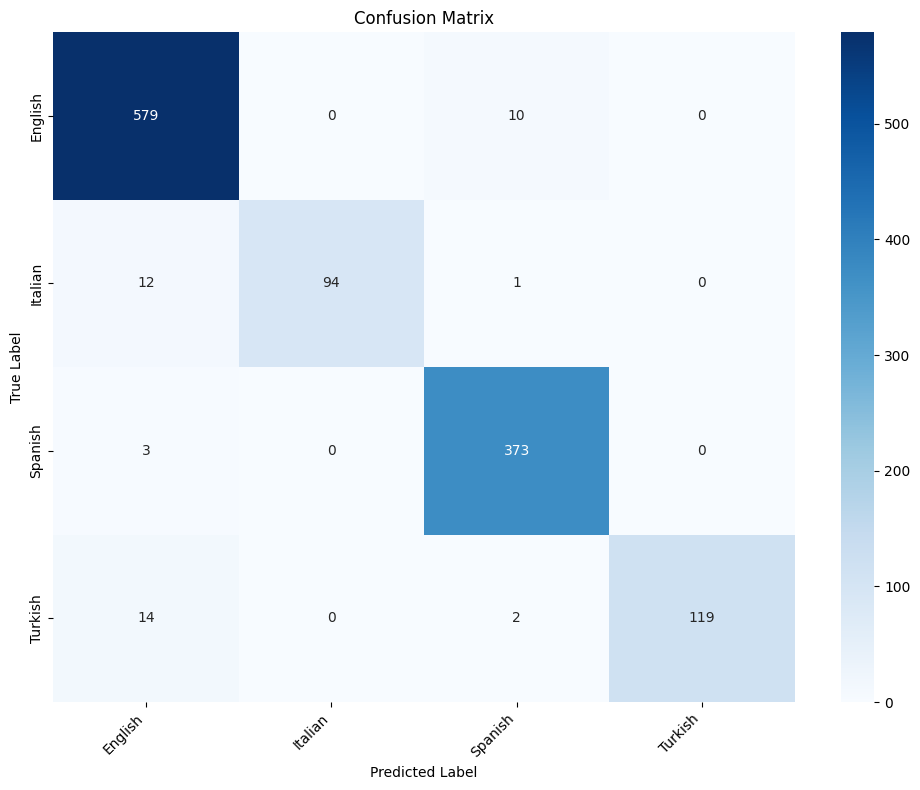

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()
plt.show()

In [ ]:
import pickle

lrFile = open('LRModel.pckl', 'wb')
pickle.dump(pipe_lr_r13, lrFile)
lrFile.close()

In [ ]:
global lrLangDetectModel
lrLangDetectFile = open('LRModel.pckl', 'rb')
lrLangDetectModel = pickle.load(lrLangDetectFile)
lrLangDetectFile.close()


In [ ]:
def tweet_lang_detect(text):
    translate_table = dict((ord(char), None) for char in string.punctuation)
    global lrLangDetectModel
    lrLangDetectFile = open('LRModel.pckl', 'rb')
    lrLangDetectModel = pickle.load(lrLangDetectFile)
    lrLangDetectFile.close()

    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.translate(translate_table)

    pred = lrLangDetectModel.predict([text])
    prob = lrLangDetectModel.predict_proba([text])
    return pred[0]

In [ ]:
tweet_lang_detect("hello, what a beautiful day ! ")

'English'

In [ ]:
tweet_lang_detect("Merhaba, ne güzel bir gün!")

'Turkish'

In [ ]:
tweet_lang_detect("hola, ¡qué hermoso día!")

'Spanish'

In [ ]:
tweet_lang_detect("ciao, che bella giornata!")

'Italian'